In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from imblearn.over_sampling import ADASYN
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/MyDrive')
import json

from binary_load import binary_load_dataset

from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers as Layer
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.regularizers import L1L2
from timeit import default_timer as timer

Mounted at /content/drive/


In [2]:
csv_loca = "star.csv"
TEST_SIZE = 0.2
VAL_SIZE = 0.2
RANDOM_STATE = 42

In [3]:
class TimingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting training")
        self.starttime = timer()

    def on_train_end(self, logs=None):
        print("End of training, took {} seconds".format(timer()-self.starttime))

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
          print("Epoch is {} and {} seconds passed".format(epoch, timer()-self.starttime))

In [4]:
def modelling(nodes1 = 8, nodes2= 6, nodes3 = 4, drop_rate= 0.2, activation= 'relu'):
  # 모델 만들기
  # 뉴런의 개수는 input과 output 사이의 숫자를 넣으라고 한다. --> 사용, 왜냐하면 시간이 적게 걸려서
  # 뉴런의 개수는 input의 2/3 정도 넣라고 한다.
  # 뉴런의 개수는 input의 두배보다는 적게 넣라고 한다.
  regularizer = L1L2(l1=0.001, l2=0.001)

  model = Sequential([Layer.Dense(12, input_shape=(8,))])
  model.add(Layer.Dense(nodes1, activation = activation, kernel_regularizer=regularizer))
  model.add(Layer.BatchNormalization())
  model.add(Layer.Dropout(drop_rate))

  model.add(Layer.Dense(nodes2, activation = activation, kernel_regularizer=regularizer))
  model.add(Layer.BatchNormalization())
  model.add(Layer.Dropout(drop_rate))

  model.add(Layer.Dense(nodes3, activation = activation, kernel_regularizer=regularizer))
  model.add(Layer.BatchNormalization())
  model.add(Layer.Dropout(drop_rate))

  model.add(Layer.Dense(1, activation = 'sigmoid'))

  # metrics에는 1이 나오는 recall 이랑 acc만 중요하다.
  metrics = [
      Recall(name = 'recall'),
      Precision(name = 'precision'),
      BinaryAccuracy(name = 'binary accuracy') # Accuracy를 사용 안 하는 이유는 Accuracy가 이상하세 나왔기 때문.
  ]

  model.compile(optimizer = 'adam',
                loss='binary_crossentropy',
                metrics = metrics)

  return model

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = binary_load_dataset(csv_loca, TEST_SIZE, VAL_SIZE, RANDOM_STATE)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11454, 8), (11454,), (2864, 8), (2864,), (3580, 8), (3580,))

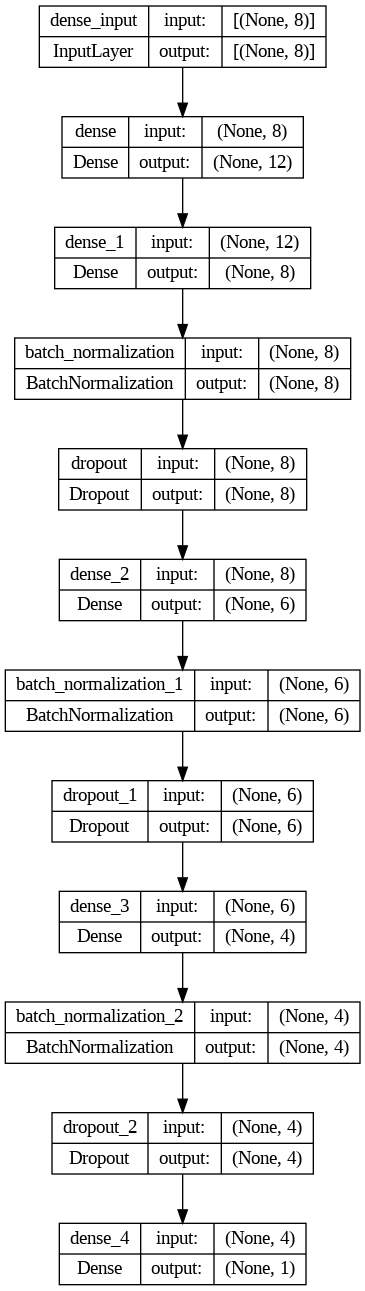

In [6]:
model = modelling()
keras.utils.plot_model(model, show_shapes=True)

In [7]:
check_path = 'model.h5'

callback = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50),
    tf.keras.callbacks.ModelCheckpoint(filepath=check_path, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=200, min_lr=0.001),
    TimingCallback()
]

In [8]:
hisotry = model.fit(X_train, y_train, batch_size= 1024, epochs= 1000,  validation_data=(X_val, y_val), callbacks=callback,verbose = 0)

Starting training
Epoch is 0 and 9.397410868999998 seconds passed
Epoch is 10 and 10.909045691000003 seconds passed
Epoch is 20 and 12.954905811000003 seconds passed
Epoch is 30 and 15.450735507999994 seconds passed
Epoch is 40 and 16.941011249 seconds passed
Epoch is 50 and 18.171439035999995 seconds passed
Epoch is 60 and 19.430529066999995 seconds passed
Epoch is 70 and 20.889645169000005 seconds passed
Epoch is 80 and 22.648085998 seconds passed
Epoch is 90 and 24.170105348999996 seconds passed
Epoch is 100 and 25.407153300000004 seconds passed
Epoch is 110 and 26.621468230999994 seconds passed
Epoch is 120 and 27.849766681000006 seconds passed
Epoch is 130 and 29.076218416000003 seconds passed
Epoch is 140 and 30.25200468 seconds passed
Epoch is 150 and 31.460780638000003 seconds passed
Epoch is 160 and 32.918538987000005 seconds passed
Epoch is 170 and 35.074036221 seconds passed
Epoch is 180 and 36.72472892099999 seconds passed
Epoch is 190 and 37.901021708 seconds passed
Epoch 

In [9]:
model.load_weights(check_path)
results = model.evaluate(X_test, y_test)

112/112 [==============================] - 0s 3ms/step - loss: 0.0734 - recall: 0.8506 - precision: 0.9300 - binary accuracy: 0.9804


In [10]:
y_test_pred = model.predict(X_test)

y_test_pred = (y_test_pred > 0.35).astype(np.float32)

112/112 [==============================] - 0s 2ms/step


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

cm = pd.DataFrame(cm)
cm.columns = ['Predicted 0', 'Predicted 1']
cm.rename(index={0: "True 0", 1: "True 1"}, inplace = True)
cm

,Predicted 0,Predicted 1
True 0,3213,39
True 1,39,289


In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.88      0.88      0.88       328

    accuracy                           0.98      3580
   macro avg       0.93      0.93      0.93      3580
weighted avg       0.98      0.98      0.98      3580



In [14]:
hist = pd.DataFrame(hisotry.history)
hist['epoch'] = hisotry.epoch
hist = hist.set_index('epoch')
hist.to_json('model2.json')

In [15]:
with open('model2.json') as json_file:
    json_file = json.loads(json_file.read())
model1_hist = pd.DataFrame(json_file)
model1_hist

,loss,recall,precision,binary accuracy,val_loss,val_recall,val_precision,val_binary accuracy,lr
0,0.929405,0.320305,0.069193,0.543129,0.727588,0.000000,0.000000,0.908520,0.001
1,0.860173,0.453765,0.099561,0.574123,0.696883,0.000000,0.000000,0.908520,0.001
2,0.791780,0.584366,0.136861,0.624411,0.670213,0.000000,0.000000,0.908520,0.001
3,0.737937,0.678742,0.170702,0.668587,0.645020,0.000000,0.000000,0.908520,0.001
4,0.706689,0.703527,0.189134,0.696613,0.623115,0.000000,0.000000,0.908520,0.001
...,...,...,...,...,...,...,...,...,...
973,0.081935,0.824595,0.919235,0.977301,0.084512,0.854962,0.896000,0.977654,0.001
974,0.079106,0.810296,0.946548,0.978435,0.078628,0.843511,0.898374,0.976955,0.001
975,0.082991,0.811249,0.930055,0.977126,0.078759,0.847328,0.913580,0.978701,0.001
976,0.081129,0.811249,0.941372,0.978086,0.085499,0.874046,0.880769,0.977654,0.001


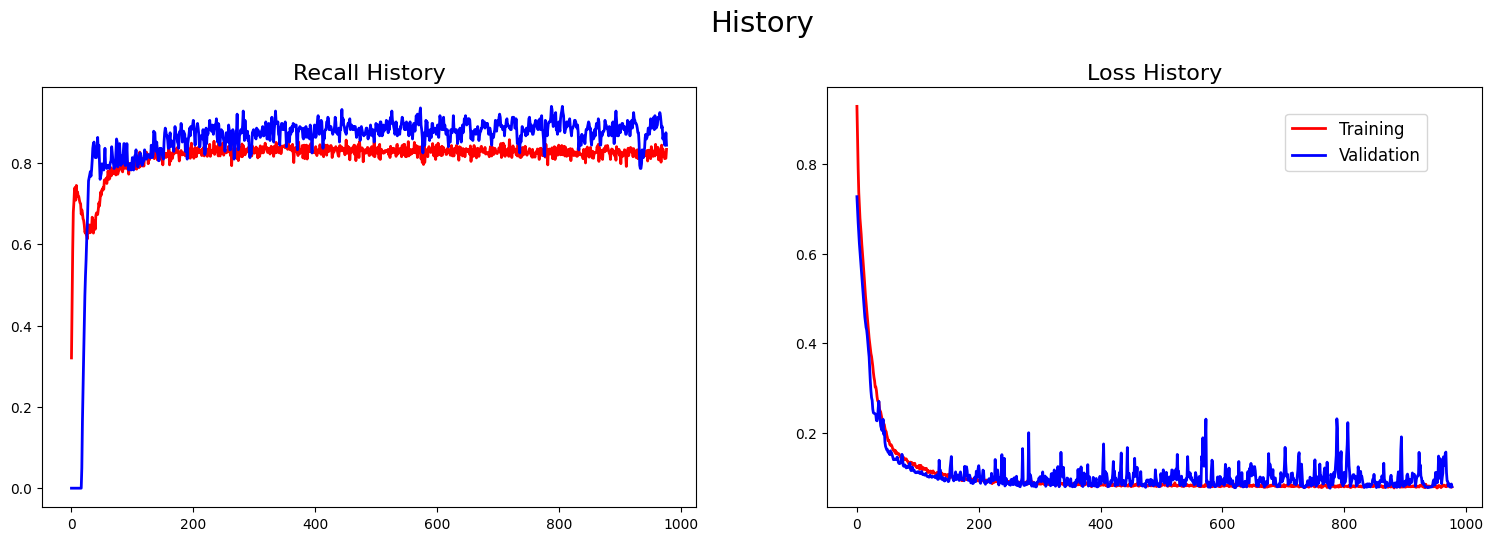

In [17]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Recall Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Recall History', fontsize = 16, y = 1)
plt.plot(hisotry.history["recall"], color='r', linewidth=2, label="Training")
plt.plot(hisotry.history["val_recall"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(hisotry.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(hisotry.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(0.7, 0.8))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model_history.png', dpi=80, bbox_inches='tight')